### Softmax Classifier <br><br>

#### 1. 소프트맥스 분류기의 구성<br><br>
##### (1) 소프트맥스 함수: $$P(y_i | x_i; W) = {e^{f_{i}} \over \Sigma_j e^{f_j}}$$<br>
(2) 소프트맥스 손실: 
$$L =  -log(\frac{e^{s_{yi}}}{\sum_{j=1}^n e^{s_j}}) =- log(P)$$<br>

$f_{j}$: 스코어 벡터의 j 번째 원소 <br>
 $f_j(s)$: 소프트맥스 함수 = ${e^{s_yi} \over \sum_{j=1}^n e^{s_j}}$
        
        

<br><br>
        
#### 2. gradient update에 대한 두 가지 전략 (naive, vectorization) <br><br>

##### (1) naive 소프트맥스 분류 (루프 사용)

* cs231n 수업 및 자료에서 표현하는 log는 $log_{10} a$ 형태가 아니라 자연로그인 $ln a$을 지칭한다는 점에 주의하자. 아래 식에서 나는 수업 자료에서 $log_{10}$로 표현된 것을 $ln a$으로 대체하여 사용한다.<br><br><br>



&nbsp;&nbsp;&nbsp;**(a) Loss(L)은 다음 같이 표현될 수 있다.**<br>
$$ L = - {e^{s_{yi}} \over \sum_{j=1}^n e^{s_j}} $$
$$ $$
$$ = - ln e^{s_{y_{i}}} + ln \sum_{j=1}^n e^{s_j} $$
$$ $$
$$ = - s_{y_{i}} + ln \sum_{j=1}^n e^{s_j} $$ <br>

&nbsp;&nbsp;&nbsp;**(b) L을 W로 미분해보자.**<br>
$$ \frac {\partial L}{\partial W} = -X_{yi} + \frac{X_i ...}{ \sum_{j=1}^n e^{s_j}},\space\space j ∈ [1,n],\space\space for\space\space s= WX+b$$<br><br><br>

In [75]:
# 나이브 소프트 맥스 (루프 사용)

import numpy as np
import matplotlib.pyplot as plt

N = 500 # number of points per class (행렬의 크기들은 cs231n assignment와 동일)
D = 3073 # dimensionality
K = 10 # number of classes

X = np.random.randn(N,D) #(500, 3073) data matrix (each row = single example)
y = np.ones(N, dtype='uint8') # (500, ) class labels


# s=WX + b 니까, 모수 W, b를 랜덤으로 초기화

W = 1 * np.random.randn(D,K) #W는 (3073, 10)

def softmax_loss_naive(W, X, y, reg): # 나이브 소프트맥스 함수 
    loss = 0.0
    dW = np.zeros_like(W) # (3073, 10)
 
    num_class=W.shape[1] # W(3073, 10) --> 10
    num_examples=X.shape[0] # X_dev(500, 3073) --> 500
   
    #score 구하기


    for i in range(num_examples):
        scores = np.dot(X[i], W)# ((500, 3073) * (3073, 10) = (500, 10)
        scores = scores - np.max(scores) #to avoid blowup

        #loss 계산하기

        exp_scores = np.exp(scores) # 표본화되지 않은 확률 (500, 10)
        sum_scores = np.sum(exp_scores)
        loss += -scores[y[i]]+np.log(sum_scores) # (10,); (표본화된 확률)

        for j in range(num_class): # 각 클래스마다 dW 업데이트, 위 수식과 대응
            dW[:, j] += (exp_scores[j]/sum_scores)*X[i]
       
        dW[:, y[i]] -= X[i]
        
        # 정규화
    
    loss /= num_examples 
    dW /= num_examples
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg * W 

    return loss, dW


loss, grad = softmax_loss_naive(W, X, y, 0.0)

print('loss: %e' % loss)
print('sanity check: %f' % (-np.log(0.1)))


        
      

loss: 8.298067e+01
sanity check: 2.302585


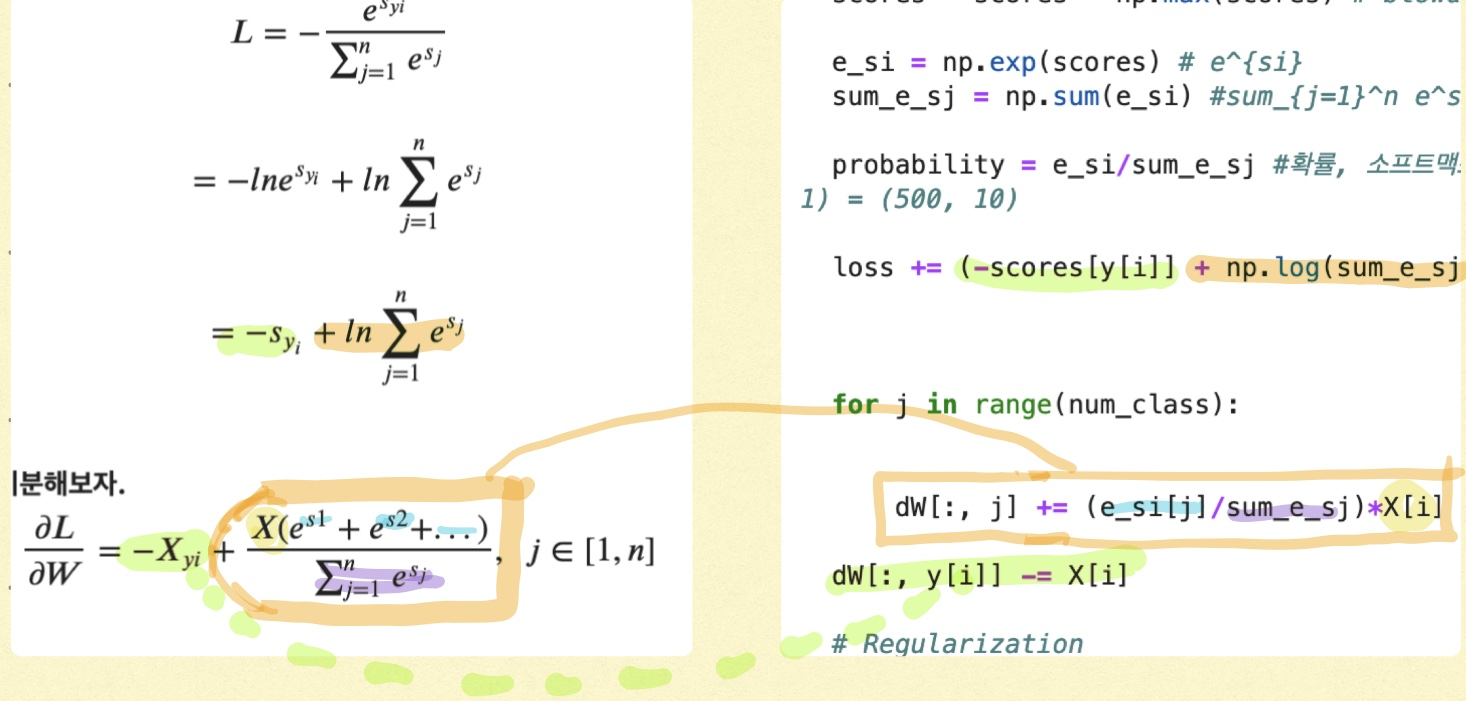

In [45]:
from IPython.display import Image
 
Image("softmax1.jpeg")



#### (2) vectorization 소프트맥스 분류<br><br>


&nbsp;&nbsp;&nbsp;(a) **L: Cross Entropy Loss**

 $$L = -y_i \sum_j log(P_i)$$<br>
 $$ $$
 
 $$ P =({e^{s_{i}} \over \Sigma_j e^{s_j}})$$

 &nbsp;&nbsp;&nbsp;&nbsp;(b) **미분하기**  <br><br>
 먼저, P를 정답 스코어로 미분해보자. 그런데, i와 j가 항상 같은 것이 아니기 때문에, 우리는 i = j 경우와 i ≠ j 경우로 나눠서 미분을 구해야 한다.
 <br><br>
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(가) i = j 경우,<br>
$$\frac{dP}{ds_{i}} =\partial(\frac{e^{s_{i}}}{\sum_{j=1}^n e^{s_j}}) = \frac{e^{s_{i}}(\sum_{j=1}^n e^{s_j})-e^{s_{i}}e^{s_{i}}}{(\sum_{j=1}^n  e^{s_j})^2}$$
$$ $$

$$= \frac{e^{s_{i}}(\sum_j e^{s_j}-e^{s_{i}})}{(\sum_{j=1}^n  e^{s_j})^2}$$
$$ $$
$$=  \frac{e^{s_{i}}}{\sum_{j=1}^n e^{s_j}}(1-\frac{e^{s_{i}}}{\sum_{j=1}^n e^{s_j}})$$
$$ $$
$$=P_{i}(1-P_{i})$$
$$ $$
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(나) i ≠ j 경우,<br>
 $$\frac{\partial P}{\partial s_j} = \frac{0(\sum_{j=1}^n e^{s_j})-e^{s_{i}}e^{s_{j}}}{(\sum_{j=1}^n  e^{s_j})^2}$$
$$ $$
$$ = -(\frac{e^{s_{i}}}{\sum_{j=1}^n e^{s_j}})(\frac{e^{s_{j}}}{\sum_{j=1}^n e^{s_j}})$$
$$ $$
$$ = -P_{i}P_j $$

이제 (a), (b)를 이용하여 L을 정답 스코어로 미분한 형태를 구해보자.<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;(c) **L의 $s_{i}$에 대하여 미분된 형태**
$$ $$
$$ $$
$$\frac{\partial L}{\partial s_{i}} = ? $$,<br>
$$\frac{\partial L}{\partial s_{i}} = -\sum_j y_j\frac{1}{P_{j}}(\frac{\partial P}{ \partial s_{i}})$$
$$ $$
$$ =-y_i(1-(P_{i})) + (-\sum_{j≠i}y_j\frac{1}{P_j}(-P_{i}P_j))$$
$$ $$
$$= -y_i+y_i P_i + \sum_{j≠i}y_jp_i$$
$$ $$
$$= P_i(y_i + \sum_{j≠i}y_j)-y_i$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$$ =P_i - y_i,\space\space\space\space for \sum_j y_j =1$$


In [77]:
# 소프트맥스의 벡터화 버젼 (루프 사용 x)
import time

N = 500 # 한 클래스 당 훈련 자료 수
D = 3073 # 차원성
K = 10 # 클래스 개수

X = np.random.randn(N,D) #(500, 3073) data matrix (each row = single example)
y = np.ones(N, dtype='uint8') # (500, ) class labels


# s=WX + b 니까, 모수 W, b를 랜덤으로 초기화

W = 1 * np.random.randn(D,K) #W는 (3073, 10)

loss = 0.0
dW = np.zeros_like(W) # (3073, 10)
 

num_class=W.shape[1] # W(3073, 10) --> 10
num_train=X.shape[0] # X_dev(500, 3073) --> 500

def vectorization_softmax(W, X, y, reg):
    
    scores=X.dot(W) #(500, 10)
    scores -= np.max(scores) # blowup 방지
    sum_exp_scores = np.sum(np.exp(scores),axis=1) # 한 행씩 모두 더해 -> (500, 1)
    
    loss = np.sum(-scores[range(num_train),y]) + np.sum(np.log(sum_exp_scores)) 
    #naive 때와 동일한 형태. loop 문에서 i가 해주던 것은 벡터화된 열벡터를 가지고 sum 함수가 대신 해준다.
    # 이 코드는 위 수식과 대응
    
    dscores = np.array(np.exp(scores)/np.matrix(sum_exp_scores).T) # 전치행렬이 사용된 이유를 잘 모르겠다. (상관관계 행렬, 역전파 참고해볼 것)
    dscores[range(num_train), y] -= 1
    dW = np.dot(X.T, dscores)
    
    loss /= num_train
    dW /= num_train
    
    loss += 0.5*reg*np.sum(W*W)
    dW += reg*W

    
    return loss, dW
    
loss, grad = vectorization_softmax(W, X, y, 0.0)

##################

print('손실: %e' % loss)
print('sanity check: %f' % (-np.log(0.1)))

손실: 8.022692e+01
sanity check: 2.302585


In [78]:

print('\n')
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X, y, 0.000005)
toc = time.time()
tt1=toc-tic
print('(1) naive 손실: %e computed in %fs' % (loss_naive, tt1))

tic = time.time()
loss_vectorized, grad_vectorized = vectorization_softmax(W, X, y, 0.000005)
toc = time.time()
tt2=toc-tic
print('(2) vectorized 손실: %e computed in %fs' % (loss_vectorized, tt2))
print('\n')
print('(3) 소요 시간 차이: %f 배' % (tt1/tt2))
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('(4) 손실 간 차이: %f' % np.abs(loss_naive - loss_vectorized))
print('(5) 그래디언트 간 차이: %f' % grad_difference)




(1) naive 손실: 8.030357e+01 computed in 0.151922s
(2) vectorized 손실: 8.030357e+01 computed in 0.005481s


(3) 소요 시간 차이: 27.717865 배
(4) 손실 간 차이: 0.000000
(5) 그래디언트 간 차이: 0.000000


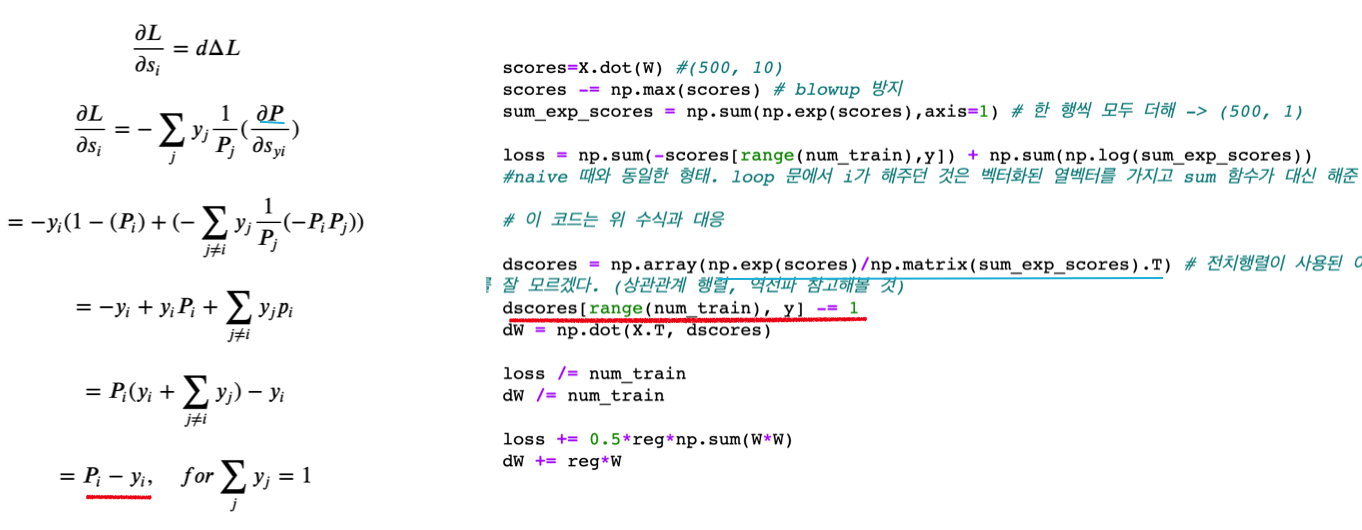

In [29]:
from IPython.display import Image
 
Image("softmax3.png")

### Reference  

     [1] https://cs231n.github.io/linear-classify/
     [2] TANG, Yichuan. Deep learning using linear support vector machines. arXiv preprint arXiv:1306.0239, 2013.
     [3] https://cs231n.github.io/neural-networks-case-study/ 
     [4] https://charlee.li/how-to-compute-the-derivative-of-softmax-and-cross-entropy/
     [5] https://mlxai.github.io/2017/01/09/implementing-softmax-classifier-with-vectorized-operations.html
     [6] https://users.wpi.edu/~jrwhitehill/CS453X_2018_Lectures/CS453X_2018_Lecture8.pdf